# Prior Networks

## Prior Networks
A prior can be thought of as a guess about the problem before any training occurs. A prior network seeks to enforce some *prior* belief about our model's parameters before encountering any data. Prior weights may be initialized with a distribution like Dirilicht, Gaussian, uniform, etc. It allows us to quantify uncertainty by randomly initializing a series of priors to generate non-deterministic predictions. It can also act as a form of regularization and prevent overfitting through its non-deterministic qualities.

##### Dataset

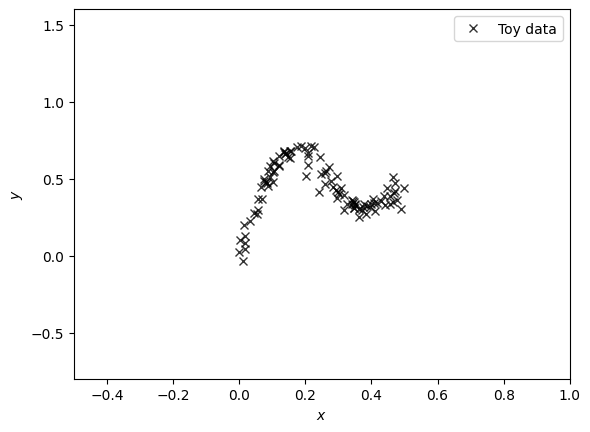

In [5]:
# Inspired by randomized_priors.py from [1]
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

# Set a seed for reproducibility
torch.manual_seed(0)

# Generate dataset and grid
X = torch.rand(100, 1) * 0.5
x_grid = torch.linspace(-5, 5, 1000).reshape(-1, 1)

# Define function
def target_toy(x, seed):
    torch.manual_seed(seed)
    epsilons = torch.randn(3) * 0.02
    return (
        x + 0.3 * torch.sin(2 * torch.pi * (x + epsilons[0])) +
        0.3 * torch.sin(4 * torch.pi * (x + epsilons[1])) + epsilons[2]
    )

# Generate target values with different seeds
Y = torch.stack([target_toy(x, seed) for x, seed in zip(X, range(X.shape[0]))])


# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

##### Model
In our implementation of a prior network, we opted to create two sets of parameters for every trained model, $\theta_{prior}$ and $\theta_{trainable}$. $\theta_{prior}$ is randomly initialized and left alone during the training process. This is done because the randomly initialized parameters of the prior network represent our prior beliefs, and we will use these parameters in our forward pass calculations. $\theta_{trainable}$ will be optimized with an Adam optimizer for mean square error loss. On a forward pass, the prior networks weights $\theta_{prior}$ will be multiplied by a hyperparameter $\beta$ that controls how biased our predictions are toward the prior. Then the trainable networks parameters, $\theta_{trainable}$ are added. This acts as a form of regularization, causing each model to be biased toward a specific prior. When utilzied within an ensemble this be utilized to quantify data uncertainty. In areas with high data uncertainty, the prior $\theta_{prior}$ should have an extreme influence on predictions due to the trainable parameters not having enough data in that region. In areas with low data uncertainty, the trainable weights $\theta_{trainable}$ should have an extreme influence on predictions. 

$\theta_{priornet}$ = $\beta * \theta_{prior} + \theta_{trainable}$

In [6]:
class GenericNet(nn.Module):
    def __init__(self, input_dim):
        super(GenericNet, self).__init__()
        self.input_dim = input_dim
        
        self.net = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=16),
            nn.ELU(),
            nn.Linear(in_features=16, out_features=1)
        )
        # Additional layers can be added here based on the architecture
        # Apply Xavier uniform initialization to the weights
        self.init_weights(self.net)

    def forward(self, x):
        return self.net(x)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, beta):
        super(Model, self).__init__()
        self.prior = GenericNet(input_dim=1)  # Specify the input dimension
        self.trainable = GenericNet(input_dim=1)  # Specify the input dimension
        self.beta = beta

    def forward(self, x):
        x1 = self.prior(x)
        x2 = self.trainable(x)
        return self.beta * x1 + x2


##### Training

In [3]:
# Function to create train state with key initialization
def create_train_optim(model, lr):
    model.train()  # Set the model in training mode
    optimizer = optim.Adam(model.trainable.parameters(), lr=lr)
    return optimizer

# Training function
def train(model, optimizer, epochs, X, Y):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = torch.mean((output - Y)**2)
        loss.backward()
        optimizer.step()
    return model

# Prediction function
def get_predictions(model, X):
    model.eval()
    with torch.no_grad():
        Y_prior = model.prior(X)
        Y_trainable = model.trainable(X)
        Y_model = model(X)
    return Y_prior, Y_trainable, Y_model

    
# Create model and optimizer
beta = 3
lr = 0.03
epochs = 2000
# Set a random seed for reproducibility
seed = 2

# Create model and optimizer
torch.manual_seed(seed)
model = Model(beta=beta)
optimizer = create_train_optim(model, lr=lr)

# Train the model
model = train(model, optimizer, epochs=epochs, X=X, Y=Y)

# Get predictions
# predictions = get_predictions(model, beta=3, X=X)
Y_prior, Y_trainable, Y_model = get_predictions(model, x_grid)

##### Visualizing

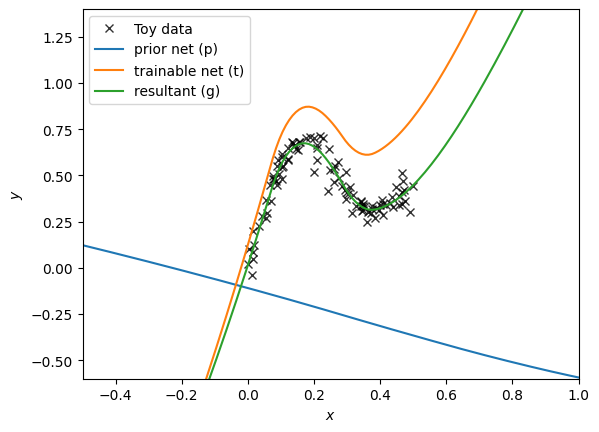

In [4]:
# Plot the results
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(X, Y, "kx", label="Toy data", alpha=0.8)
plt.plot(x_grid, 3 * Y_prior, label="prior net (p)")
plt.plot(x_grid, Y_trainable, label="trainable net (t)")
plt.plot(x_grid, Y_model, label="resultant (g)")
# plt.title('Predictions of the prior network: random function')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.6, 1.4)
plt.legend()

# plt.savefig("randomized_priors_single_model.pdf")
# plt.savefig("randomized_priors_single_model.png")

plt.show()

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.